## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [9]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

reduce_lr_factor = [0.5, 0.2]
redice_lr_patient = [5, 2]

In [10]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=reduce_patient, 
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5


W0917 22:57:20.960724  9676 deprecation_wrapper.py:119] From C:\Users\Hsin-PC\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0917 22:57:22.612853  9676 deprecation_wrapper.py:119] From C:\Users\Hsin-PC\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0917 22:57:22.629231  9676 deprecation_wrapper.py:119] From C:\Users\Hsin-PC\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

W0917 22:57:22.878634  9676 deprecation.py:323] From C:\Users\Hsin-PC\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 12s 247us/step - loss: 2.2468 - acc: 0.2559 - val_loss: 2.1075 - val_acc: 0.2958
Epoch 2/25
50000/50000 [==============================] - 6s 119us/step - loss: 1.7705 - acc: 0.3799 - val_loss: 1.8161 - val_acc: 0.3709
Epoch 3/25
50000/50000 [==============================] - 6s 116us/step - loss: 1.6559 - acc: 0.4190 - val_loss: 1.7050 - val_acc: 0.4012
Epoch 4/25
50000/50000 [==============================] - 6s 115us/step - loss: 1.5898 - acc: 0.4437 - val_loss: 1.6575 - val_acc: 0.4182
Epoch 5/25
50000/50000 [==============================] - 6s 115us/step - loss: 1.5386 - acc: 0.4590 - val_loss: 1.6185 - val_acc: 0.4294
Epoch 6/25
50000/50000 [==============================] - 6s 119us/step - loss: 1.4980 - acc: 0.4735 - val_loss: 1.5879 - val_acc: 0.4403
Epoch 7/25
50000/50000 [==============================] - 6s 120us/step - loss: 1.4654 - acc: 0.4866 - val_loss: 1.5738 -

50000/50000 [==============================] - 6s 121us/step - loss: 1.1911 - acc: 0.5854 - val_loss: 1.4542 - val_acc: 0.4888
Epoch 24/25
50000/50000 [==============================] - 6s 121us/step - loss: 1.1803 - acc: 0.5903 - val_loss: 1.4574 - val_acc: 0.4896

Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 25/25
50000/50000 [==============================] - 6s 120us/step - loss: 1.1705 - acc: 0.5939 - val_loss: 1.4448 - val_acc: 0.4905
Numbers of exp: 2, reduce_factor: 0.20, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)               1024 

Epoch 10/25
50000/50000 [==============================] - 6s 121us/step - loss: 1.5938 - acc: 0.4430 - val_loss: 1.6697 - val_acc: 0.4146
Epoch 11/25
50000/50000 [==============================] - 6s 121us/step - loss: 1.5730 - acc: 0.4505 - val_loss: 1.6518 - val_acc: 0.4195
Epoch 12/25
50000/50000 [==============================] - 6s 120us/step - loss: 1.5547 - acc: 0.4569 - val_loss: 1.6410 - val_acc: 0.4218
Epoch 13/25
50000/50000 [==============================] - 6s 121us/step - loss: 1.5375 - acc: 0.4634 - val_loss: 1.6272 - val_acc: 0.4281
Epoch 14/25
50000/50000 [==============================] - 6s 121us/step - loss: 1.5219 - acc: 0.4673 - val_loss: 1.6195 - val_acc: 0.4328
Epoch 15/25
50000/50000 [==============================] - 6s 121us/step - loss: 1.5065 - acc: 0.4740 - val_loss: 1.6086 - val_acc: 0.4328
Epoch 16/25
50000/50000 [==============================] - 6s 121us/step - loss: 1.4916 - acc: 0.4794 - val_loss: 1.6001 - val_acc: 0.4373
Epoch 17/25
50000/50000 [==

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 8s 169us/step - loss: 1.7925 - acc: 0.3760 - val_loss: 1.8880 - val_acc: 0.3619
Epoch 2/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.5090 - acc: 0.4666 - val_loss: 1.6613 - val_acc: 0.4131
Epoch 3/25
50000/50000 [==============================] - 7s 133us/step - loss: 1.4150 - acc: 0.5001 - val_loss: 1.6174 - val_acc: 0.4313
Epoch 4/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.3424 - acc: 0.5287 - val_loss: 1.6069 - val_acc: 0.4327
Epoch 5/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.2886 - acc: 0.5458 - val_loss: 1.5625 - val_acc: 0.4468
Epoch 6/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.2356 - acc: 0.5676 - val_loss: 1.5244 - val_acc: 0.4522
Epoch 7/25
50000/50000 [==============================] - 7s 131us/step - loss: 1.1898 - acc: 0.5838 - val_loss: 1.4823 - 

50000/50000 [==============================] - 7s 132us/step - loss: 1.3217 - acc: 0.5429 - val_loss: 1.5188 - val_acc: 0.4693
Epoch 22/25
50000/50000 [==============================] - 7s 131us/step - loss: 1.3134 - acc: 0.5466 - val_loss: 1.5111 - val_acc: 0.4767
Epoch 23/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.3037 - acc: 0.5504 - val_loss: 1.5087 - val_acc: 0.4744
Epoch 24/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.2942 - acc: 0.5540 - val_loss: 1.5049 - val_acc: 0.4775
Epoch 25/25
50000/50000 [==============================] - 7s 133us/step - loss: 1.2859 - acc: 0.5579 - val_loss: 1.5023 - val_acc: 0.4794
Numbers of exp: 7, reduce_factor: 0.20, reduce_patient: 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3072)              0         
_____________________________________________________________

50000/50000 [==============================] - 6s 127us/step - loss: 1.1534 - acc: 0.5921 - val_loss: 1.7984 - val_acc: 0.3832
Epoch 9/25
50000/50000 [==============================] - 6s 127us/step - loss: 1.1133 - acc: 0.6071 - val_loss: 2.0792 - val_acc: 0.3410
Epoch 10/25
50000/50000 [==============================] - 6s 129us/step - loss: 1.0790 - acc: 0.6191 - val_loss: 1.9116 - val_acc: 0.3902
Epoch 11/25
50000/50000 [==============================] - 6s 127us/step - loss: 1.0448 - acc: 0.6303 - val_loss: 1.5980 - val_acc: 0.4560
Epoch 12/25
50000/50000 [==============================] - 6s 128us/step - loss: 1.0103 - acc: 0.6463 - val_loss: 1.8866 - val_acc: 0.4092
Epoch 13/25
50000/50000 [==============================] - 6s 128us/step - loss: 0.9751 - acc: 0.6572 - val_loss: 1.7417 - val_acc: 0.4164
Epoch 14/25
50000/50000 [==============================] - 6s 130us/step - loss: 0.9426 - acc: 0.6706 - val_loss: 2.2601 - val_acc: 0.3754
Epoch 15/25
50000/50000 [===============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 9s 176us/step - loss: 2.8528 - acc: 0.1203 - val_loss: 2.7362 - val_acc: 0.1590
Epoch 2/25
50000/50000 [==============================] - 6s 127us/step - loss: 2.6102 - acc: 0.1663 - val_loss: 2.6079 - val_acc: 0.1912
Epoch 3/25
50000/50000 [==============================] - 6s 128us/step - loss: 2.4540 - acc: 0.2029 - val_loss: 2.4736 - val_acc: 0.2201
Epoch 4/25
50000/50000 [==============================] - 6s 127us/step - loss: 2.3440 - acc: 0.2317 - val_loss: 2.3673 - val_acc: 0.2446
Epoch 5/25
50000/50000 [==============================] - 6s 127us/step - loss: 2.2601 - acc: 0.2519 - val_loss: 2.2816 - val_acc: 0.2579
Epoch 6/25
50000/50000 [==============================] - 6s 128us/step - loss: 2.1905 - acc: 0.2713 - val_loss: 2.2103 - val_acc: 0.2756
Epoch 7/25
50000/50000 [==============================] - 6s 129us/step - loss: 2.1349 - acc: 0.2833 - val_loss: 2.1549 - 

Epoch 24/25
50000/50000 [==============================] - 6s 128us/step - loss: 1.7474 - acc: 0.3932 - val_loss: 1.8302 - val_acc: 0.3717
Epoch 25/25
50000/50000 [==============================] - 6s 128us/step - loss: 1.7370 - acc: 0.3957 - val_loss: 1.8228 - val_acc: 0.3742


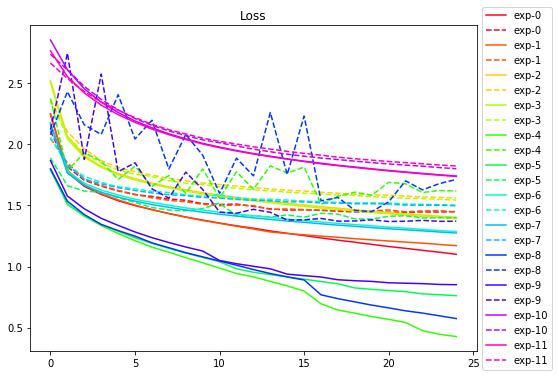

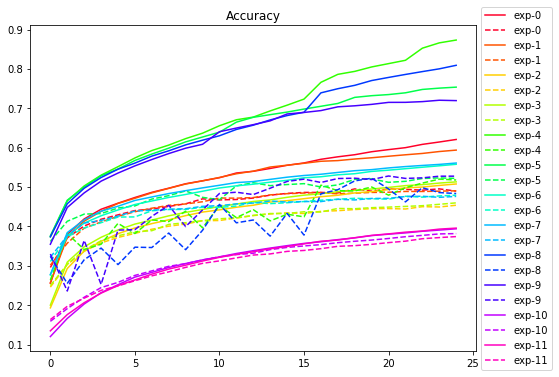

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()